In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

# Prophet imports
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Scikit-learn imports
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    silhouette_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler, 
    LabelEncoder, 
    MinMaxScaler
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.decomposition import PCA

# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


2025-07-16 15:54:07.611575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752681248.025548      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752681248.141893      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/road-accidents-dataset/Road Accident Data.csv


In [2]:
df = pd.read_csv('/kaggle/input/road-accidents-dataset/Road Accident Data.csv')
df.head()

Accident_Index Accident Date Day_of_Week          Junction_Control  \
0      BS0000001    01-01-2021    Thursday  Give way or uncontrolled   
1      BS0000002    05-01-2021      Monday  Give way or uncontrolled   
2      BS0000003    04-01-2021      Sunday  Give way or uncontrolled   
3      BS0000004    05-01-2021      Monday       Auto traffic signal   
4      BS0000005    06-01-2021     Tuesday       Auto traffic signal   

           Junction_Detail Accident_Severity   Latitude  \
0  T or staggered junction           Serious  51.512273   
1               Crossroads           Serious  51.514399   
2  T or staggered junction            Slight  51.486668   
3  T or staggered junction           Serious  51.507804   
4               Crossroads           Serious  51.482076   

        Light_Conditions Local_Authority_(District) Carriageway_Hazards  ...  \
0               Daylight     Kensington and Chelsea                 NaN  ...   
1               Daylight     Kensington and Chelsea                 NaN  ...   
2               Daylight     Kensington and Chelsea                 NaN  ...   
3               Daylight     Kensington and Chelsea                 NaN  ...   
4  Darkness - lights lit     Kensington and Chelsea                 NaN  ...   

   Number_of_Casualties  Number_of_Vehicles         Police_Force  \
0                     1                   2  Metropolitan Police   
1                    11                   2  Metropolitan Police   
2                     1                   2  Metropolitan Police   
3                     1                   2  Metropolitan Police   
4                     1                   2  Metropolitan Police   

  Road_Surface_Conditions           Road_Type Speed_limit   Time  \
0                     Dry      One way street          30  15:11   
1             Wet or damp  Single carriageway          30  10:59   
2                     Dry  Single carriageway          30  14:19   
3            Frost or ice  Single carriageway          30  08:10   
4                     Dry  Single carriageway          30  17:25   

  Urban_or_Rural_Area  Weather_Conditions           Vehicle_Type  
0               Urban  Fine no high winds                    Car  
1               Urban  Fine no high winds  Taxi/Private hire car  
2               Urban  Fine no high winds  Taxi/Private hire car  
3               Urban               Other  Motorcycle over 500cc  
4               Urban  Fine no high winds                    Car  

[5 rows x 21 columns]

In [3]:
print(df)

       Accident_Index Accident Date Day_of_Week              Junction_Control  \
0           BS0000001    01-01-2021    Thursday      Give way or uncontrolled   
1           BS0000002    05-01-2021      Monday      Give way or uncontrolled   
2           BS0000003    04-01-2021      Sunday      Give way or uncontrolled   
3           BS0000004    05-01-2021      Monday           Auto traffic signal   
4           BS0000005    06-01-2021     Tuesday           Auto traffic signal   
...               ...           ...         ...                           ...   
307968      BS0307969    18-02-2022    Thursday  Data missing or out of range   
307969      BS0307970    21-02-2022      Sunday  Data missing or out of range   
307970      BS0307971    23-02-2022     Tuesday      Give way or uncontrolled   
307971      BS0307972    23-02-2022     Tuesday      Give way or uncontrolled   
307972      BS0307973    28-02-2022      Sunday      Give way or uncontrolled   

                           

In [4]:
for col in df.columns:
    if col != 'Accident_Index':
        print(f"\n--- Unique values in '{col}' ---")
        print(df[col].unique())

print('\n')
print(df['Carriageway_Hazards'].unique())
print(df['Carriageway_Hazards'].head(10))


--- Unique values in 'Accident Date' ---
['01-01-2021' '05-01-2021' '04-01-2021' '06-01-2021' '08-01-2021'
 '02-01-2021' '07-01-2021' '10-01-2021' '16-01-2021' '12-01-2021'
 '09-01-2021' '17-01-2021' '25-01-2021' '26-01-2021' '19-01-2021'
 '27-01-2021' '21-01-2021' '22-01-2021' '31-01-2021' '03-02-2021'
 '29-01-2021' '28-01-2021' '20-01-2021' '15-01-2021' '09-02-2021'
 '23-01-2021' '10-02-2021' '30-01-2021' '12-02-2021' '16-02-2021'
 '14-02-2021' '18-02-2021' '21-02-2021' '15-02-2021' '20-02-2021'
 '27-02-2021' '18-01-2021' '07-02-2021' '23-02-2021' '22-02-2021'
 '26-02-2021' '04-03-2021' '03-03-2021' '06-03-2021' '17-02-2021'
 '09-03-2021' '10-03-2021' '02-03-2021' '25-02-2021' '14-03-2021'
 '28-02-2021' '11-02-2021' '01-03-2021' '13-03-2021' '17-03-2021'
 '24-02-2021' '20-03-2021' '05-02-2021' '21-03-2021' '24-03-2021'
 '23-03-2021' '25-03-2021' '27-03-2021' '28-03-2021' '18-03-2021'
 '30-03-2021' '01-04-2021' '31-03-2021' '03-04-2021' '06-04-2021'
 '26-03-2021' '22-03-2021' '29-03-

In [5]:
#Encoding dates into numbers [0::6]
print(df['Day_of_Week'].dtype)
days_map = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6
}


df['Day_of_Week'] = df['Day_of_Week'].map(days_map)


print(df.head())


object
  Accident_Index Accident Date  Day_of_Week          Junction_Control  \
0      BS0000001    01-01-2021            4  Give way or uncontrolled   
1      BS0000002    05-01-2021            1  Give way or uncontrolled   
2      BS0000003    04-01-2021            0  Give way or uncontrolled   
3      BS0000004    05-01-2021            1       Auto traffic signal   
4      BS0000005    06-01-2021            2       Auto traffic signal   

           Junction_Detail Accident_Severity   Latitude  \
0  T or staggered junction           Serious  51.512273   
1               Crossroads           Serious  51.514399   
2  T or staggered junction            Slight  51.486668   
3  T or staggered junction           Serious  51.507804   
4               Crossroads           Serious  51.482076   

        Light_Conditions Local_Authority_(District) Carriageway_Hazards  ...  \
0               Daylight     Kensington and Chelsea                 NaN  ...   
1               Daylight     Kensington

In [6]:
print(df['Junction_Control'].unique())


df['Junction_Control'] = df['Junction_Control'].str.strip().str.lower()


c = {
    'give way or uncontrolled': 0,
    'auto traffic signal': 1,
    'data missing or out of range': np.nan,
    'authorised person': 2,
    'stop sign': 3,
    'not at junction or within 20 metres': 4,
    'auto traffic sigl': 5  
}


df['Junction_Control'] = df['Junction_Control'].map(c)


print(df['Junction_Control'].head())

['Give way or uncontrolled' 'Auto traffic signal'
 'Data missing or out of range' 'Authorised person' 'Stop sign'
 'Not at junction or within 20 metres' 'Auto traffic sigl']
0    0.0
1    0.0
2    0.0
3    1.0
4    1.0
Name: Junction_Control, dtype: float64


In [7]:
df = df.apply(lambda col: col.str.lower().str.strip() if col.dtype == 'object' else col)

In [8]:
#Junction_Detail
df['Junction_Detail'] = df['Junction_Detail'].map({
    't or staggered junction': 0,
    'crossroads': 1,
    'not at junction or within 20 metres': 2,
    'roundabout': 3,
    'mini-roundabout': 4,
    'more than 4 arms (not roundabout)': 5,
    'private drive or entrance': 6,
    'slip road': 7,
    'other junction': 8
})

# Accident_Severity
df['Accident_Severity'] = df['Accident_Severity'].map({
    'slight': 0,
    'serious': 1,
    'fatal': 2,
    'fetal': 2   # handling typo
})

# Light_Conditions
df['Light_Conditions'] = df['Light_Conditions'].map({
    'daylight': 0,
    'darkness - lights lit': 1,
    'darkness - lighting unknown': 2,
    'darkness - lights unlit': 3,
    'darkness - no lighting': 4
})

# Carriageway_Hazards
df['Carriageway_Hazards'] = df['Carriageway_Hazards'].map({
    'pedestrian in carriageway - not injured': 0,
    'other object on road': 1,
    'any animal in carriageway (except ridden horse)': 2,
    'previous accident': 3,
    'vehicle load on road': 4
})

# Road_Surface_Conditions
df['Road_Surface_Conditions'] = df['Road_Surface_Conditions'].map({
    'dry': 0,
    'wet or damp': 1,
    'frost or ice': 2,
    'snow': 3,
    'flood over 3cm. deep': 4
})

# Road_Type
df['Road_Type'] = df['Road_Type'].map({
    'one way street': 0,
    'single carriageway': 1,
    'dual carriageway': 2,
    'roundabout': 3,
    'slip road': 4
})

# Weather_Conditions
df['Weather_Conditions'] = df['Weather_Conditions'].map({
    'fine no high winds': 0,
    'fine + high winds': 1,
    'raining no high winds': 2,
    'raining + high winds': 3,
    'snowing no high winds': 4,
    'snowing + high winds': 5,
    'fog or mist': 6,
    'other': 7
})

# Vehicle_Type
df['Vehicle_Type'] = df['Vehicle_Type'].map({
    'car': 0,
    'taxi/private hire car': 1,
    'motorcycle over 500cc': 2,
    'van / goods 3.5 tonnes mgw or under': 3,
    'goods over 3.5t. and under 7.5t': 4,
    'goods 7.5 tonnes mgw and over': 5,
    'motorcycle 125cc and under': 6,
    'motorcycle 50cc and under': 7,
    'motorcycle over 125cc and up to 500cc': 8,
    'pedal cycle': 9,
    'bus or coach (17 or more pass seats)': 10,
    'minibus (8 - 16 passenger seats)': 11,
    'agricultural vehicle': 12,
    'ridden horse': 13,
    'other vehicle': 14
})

# Police_Force and Local_Authority_(District) as categorical codes
df['Police_Force'] = df['Police_Force'].astype('category').cat.codes
df['Local_Authority_(District)'] = df['Local_Authority_(District)'].astype('category').cat.codes

#urban and rural
df['Urban_or_Rural_Area'] = df['Urban_or_Rural_Area'].map({
    'urban':1,
    'rural':0
})

In [9]:
print(df.dtypes)
print(df.head())

Accident_Index                 object
Accident Date                  object
Day_of_Week                     int64
Junction_Control              float64
Junction_Detail                 int64
Accident_Severity               int64
Latitude                      float64
Light_Conditions                int64
Local_Authority_(District)      int16
Carriageway_Hazards           float64
Longitude                     float64
Number_of_Casualties            int64
Number_of_Vehicles              int64
Police_Force                     int8
Road_Surface_Conditions         int64
Road_Type                       int64
Speed_limit                     int64
Time                           object
Urban_or_Rural_Area             int64
Weather_Conditions              int64
Vehicle_Type                    int64
dtype: object
  Accident_Index Accident Date  Day_of_Week  Junction_Control  \
0      bs0000001    01-01-2021            4               0.0   
1      bs0000002    05-01-2021            1               

In [10]:
print(df['Carriageway_Hazards'].unique)

<bound method Series.unique of 0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
307968    NaN
307969    NaN
307970    NaN
307971    NaN
307972    1.0
Name: Carriageway_Hazards, Length: 307973, dtype: float64>


In [11]:
for col in df.columns:
    if col != 'Accident_Index':
        print(f"\n--- Unique values in '{col}' ---")
        print(df[col].unique())


--- Unique values in 'Accident Date' ---
['01-01-2021' '05-01-2021' '04-01-2021' '06-01-2021' '08-01-2021'
 '02-01-2021' '07-01-2021' '10-01-2021' '16-01-2021' '12-01-2021'
 '09-01-2021' '17-01-2021' '25-01-2021' '26-01-2021' '19-01-2021'
 '27-01-2021' '21-01-2021' '22-01-2021' '31-01-2021' '03-02-2021'
 '29-01-2021' '28-01-2021' '20-01-2021' '15-01-2021' '09-02-2021'
 '23-01-2021' '10-02-2021' '30-01-2021' '12-02-2021' '16-02-2021'
 '14-02-2021' '18-02-2021' '21-02-2021' '15-02-2021' '20-02-2021'
 '27-02-2021' '18-01-2021' '07-02-2021' '23-02-2021' '22-02-2021'
 '26-02-2021' '04-03-2021' '03-03-2021' '06-03-2021' '17-02-2021'
 '09-03-2021' '10-03-2021' '02-03-2021' '25-02-2021' '14-03-2021'
 '28-02-2021' '11-02-2021' '01-03-2021' '13-03-2021' '17-03-2021'
 '24-02-2021' '20-03-2021' '05-02-2021' '21-03-2021' '24-03-2021'
 '23-03-2021' '25-03-2021' '27-03-2021' '28-03-2021' '18-03-2021'
 '30-03-2021' '01-04-2021' '31-03-2021' '03-04-2021' '06-04-2021'
 '26-03-2021' '22-03-2021' '29-03-

In [12]:

print(df.columns.tolist())
print(df.columns)

['Accident_Index', 'Accident Date', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions', 'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type']
Index(['Accident_Index', 'Accident Date', 'Day_of_Week', 'Junction_Control',
       'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type'],
      dtype='object')


Training LinearRegression...
Training Ridge...
Training Lasso...
Training DecisionTree...
Training RandomForest...
Training SVR...
Training Prophet...


15:54:38 - cmdstanpy - INFO - Chain [1] start processing
15:54:38 - cmdstanpy - INFO - Chain [1] done processing
15:54:38 - cmdstanpy - INFO - Chain [1] start processing
15:54:39 - cmdstanpy - INFO - Chain [1] done processing
15:54:39 - cmdstanpy - INFO - Chain [1] start processing
15:54:39 - cmdstanpy - INFO - Chain [1] done processing
15:54:39 - cmdstanpy - INFO - Chain [1] start processing
15:54:39 - cmdstanpy - INFO - Chain [1] done processing
15:54:40 - cmdstanpy - INFO - Chain [1] start processing
15:54:40 - cmdstanpy - INFO - Chain [1] done processing


Model Comparison:
              Model                                        Best Params   RMSE  \
2             Lasso                                     {'alpha': 0.1}   8.29   
6           Prophet  {'changepoint_prior_scale': 0.01, 'seasonality...   8.41   
1             Ridge                                     {'alpha': 0.1}   8.44   
0  LinearRegression                                                 {}   8.47   
5               SVR    {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}   8.50   
4      RandomForest              {'max_depth': 10, 'n_estimators': 50}  10.90   
3      DecisionTree                                   {'max_depth': 5}  15.85   

   Accuracy (%)  R2_Score  
2         98.27    0.9920  
6         98.25    0.9917  
1         98.22    0.9917  
0         98.20    0.9916  
5         98.23    0.9915  
4         97.59    0.9861  
3         96.35    0.9706  


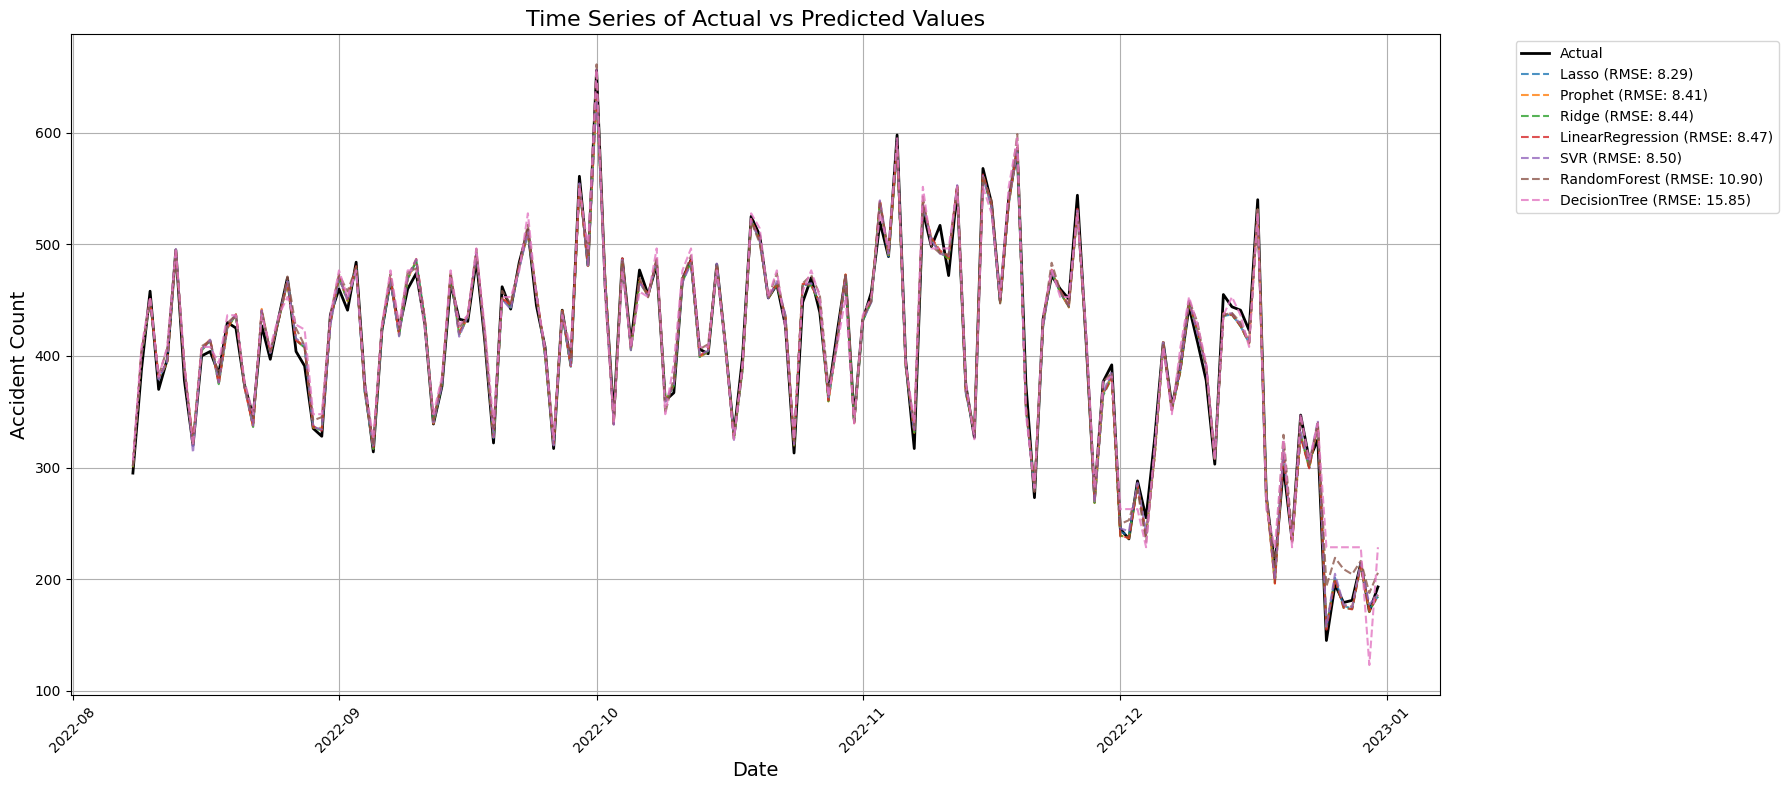

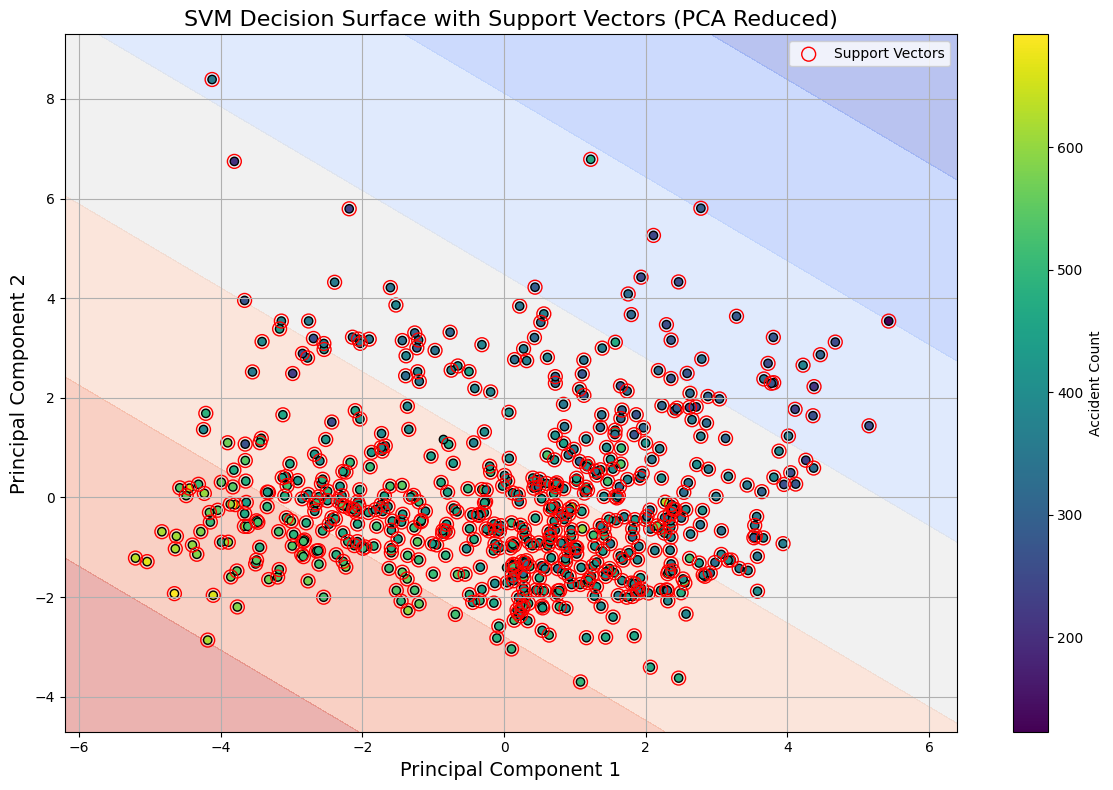

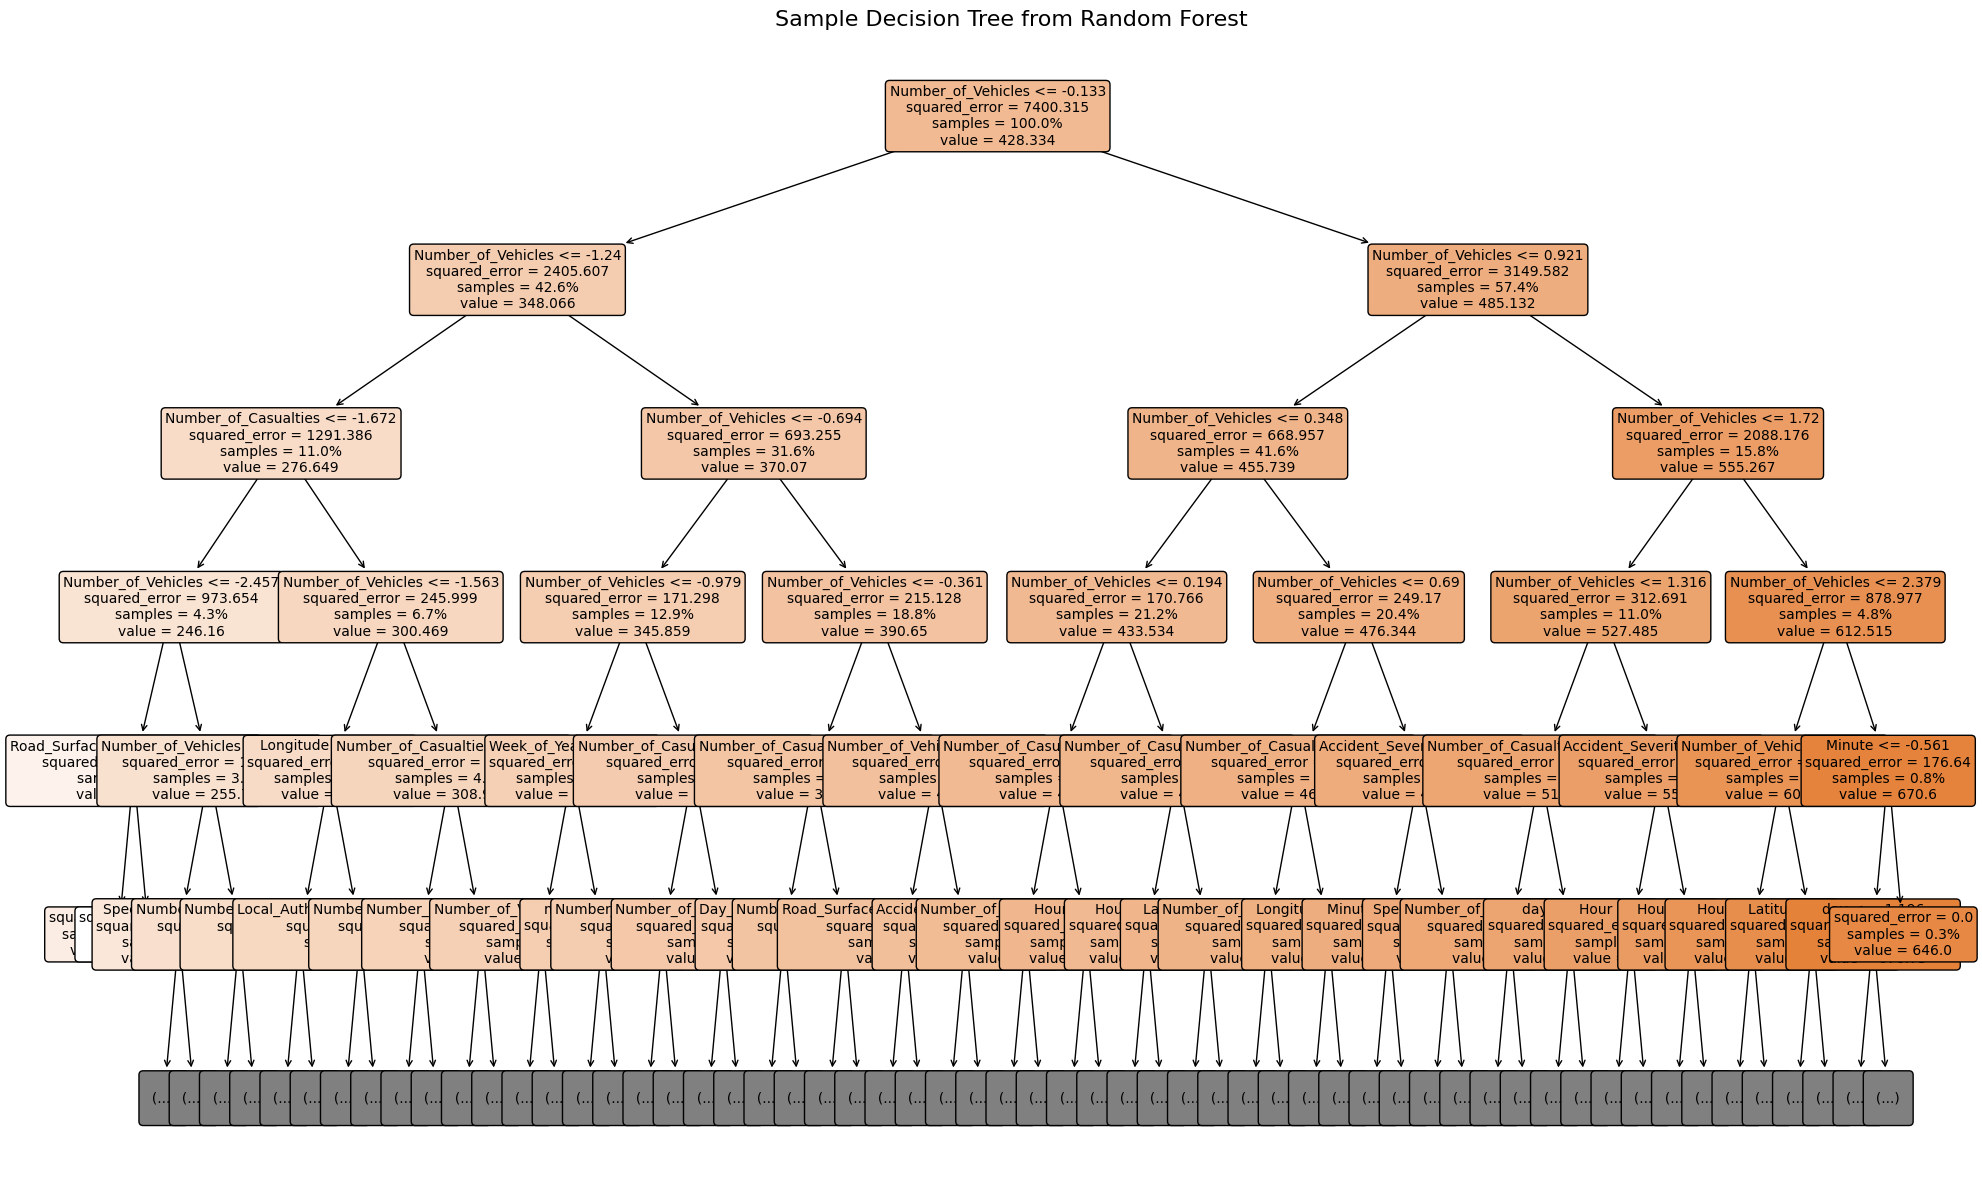

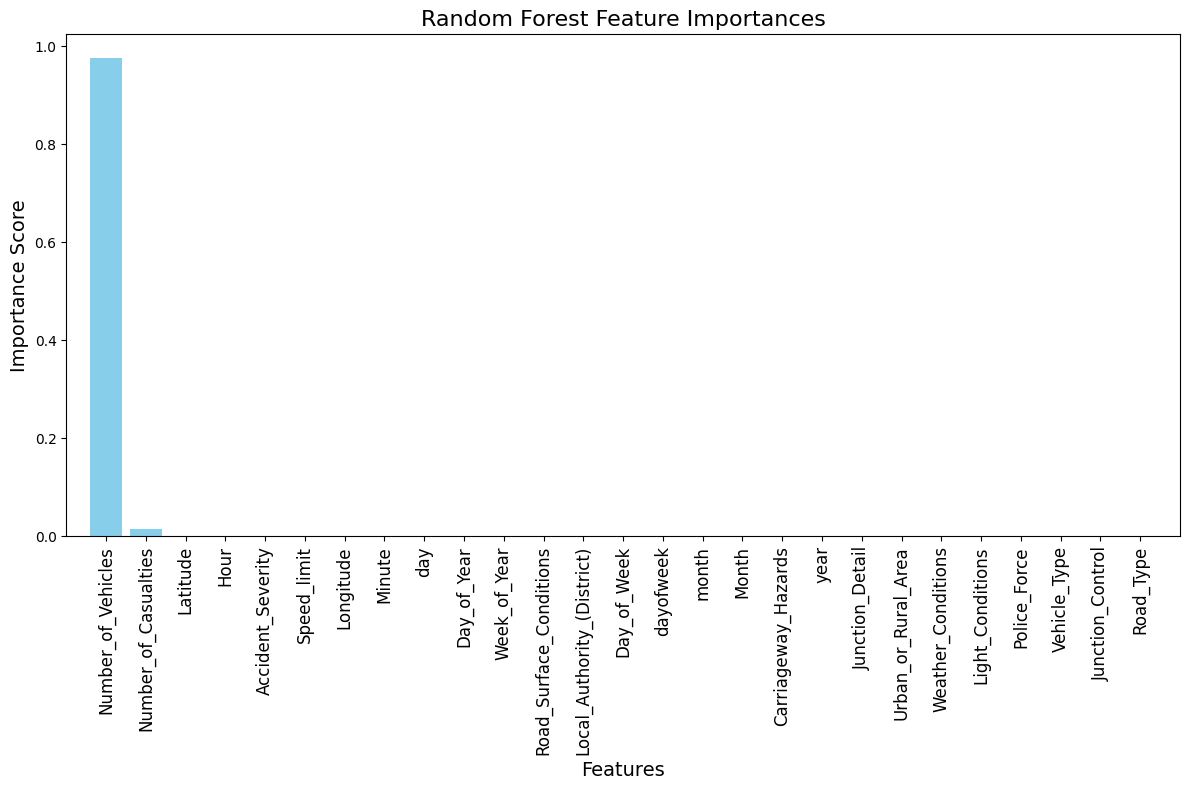

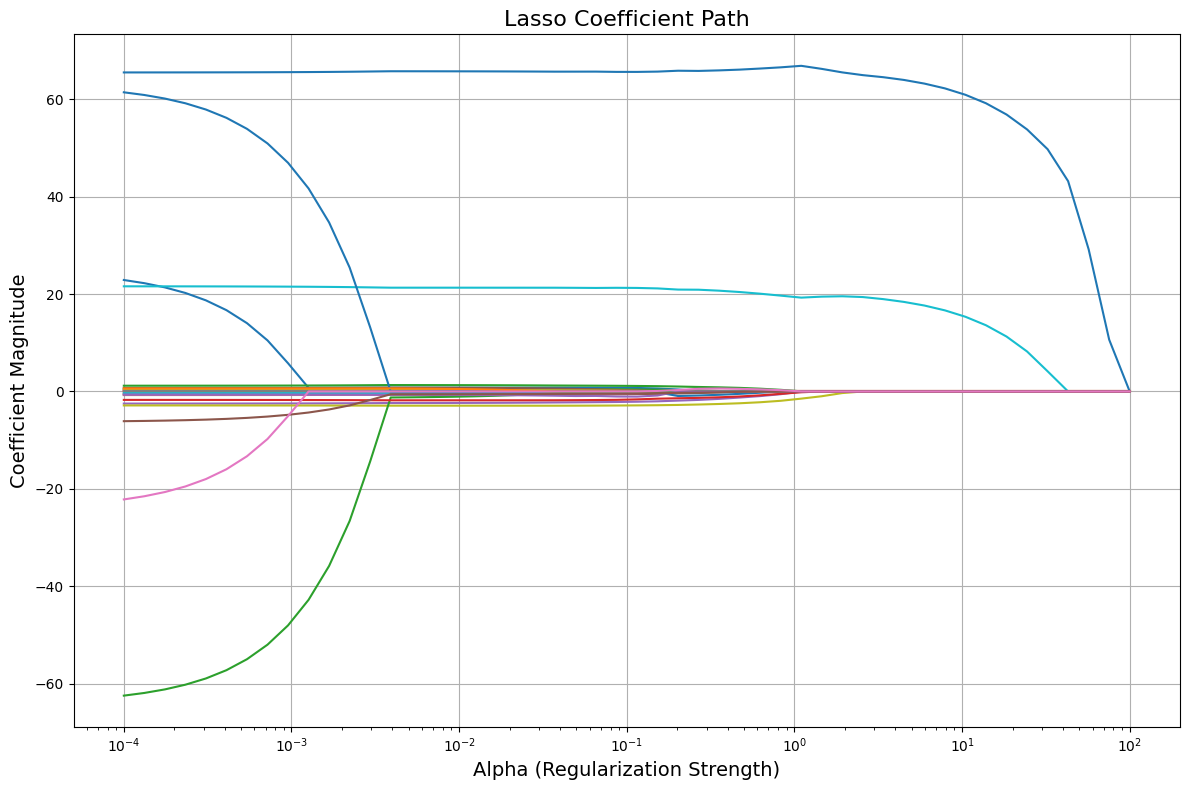

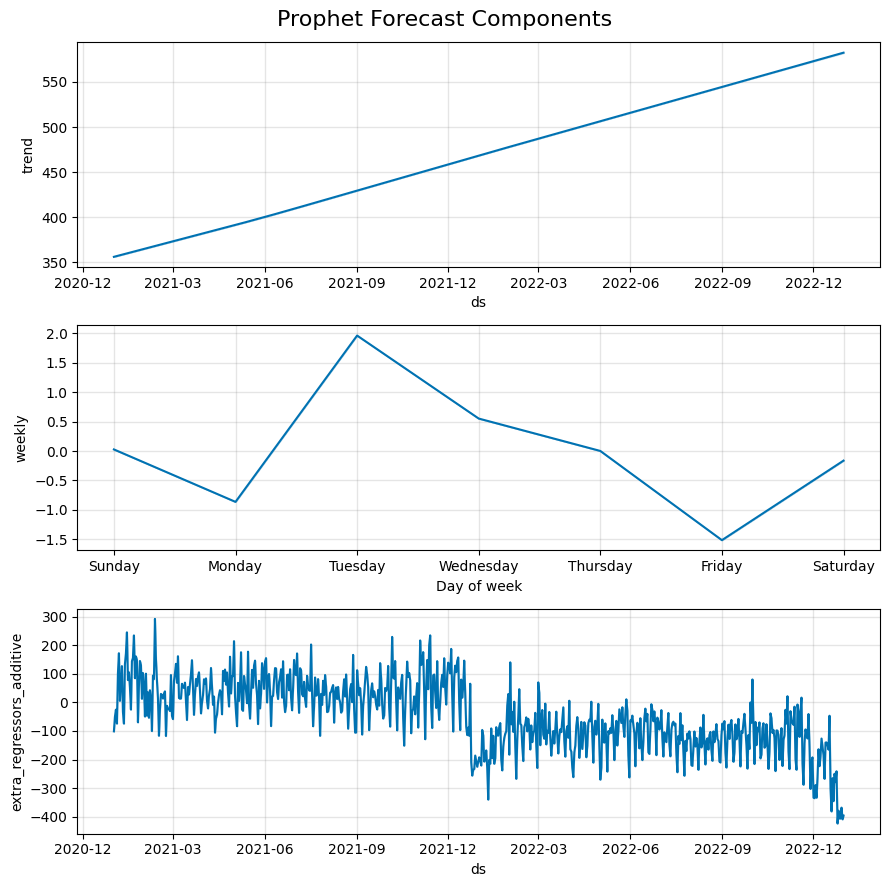

  0%|          | 0/1 [00:00<?, ?it/s]

15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing


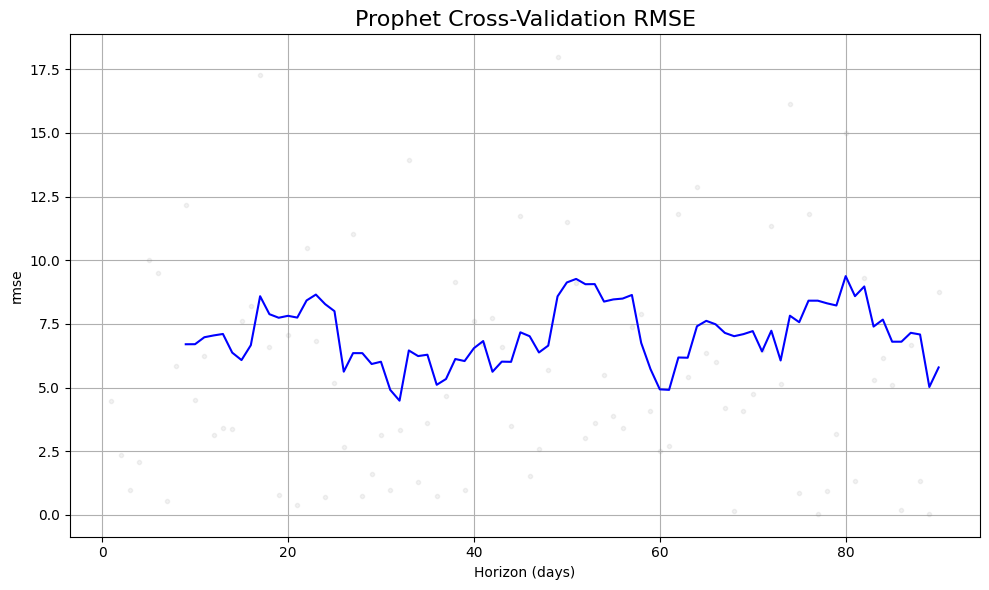

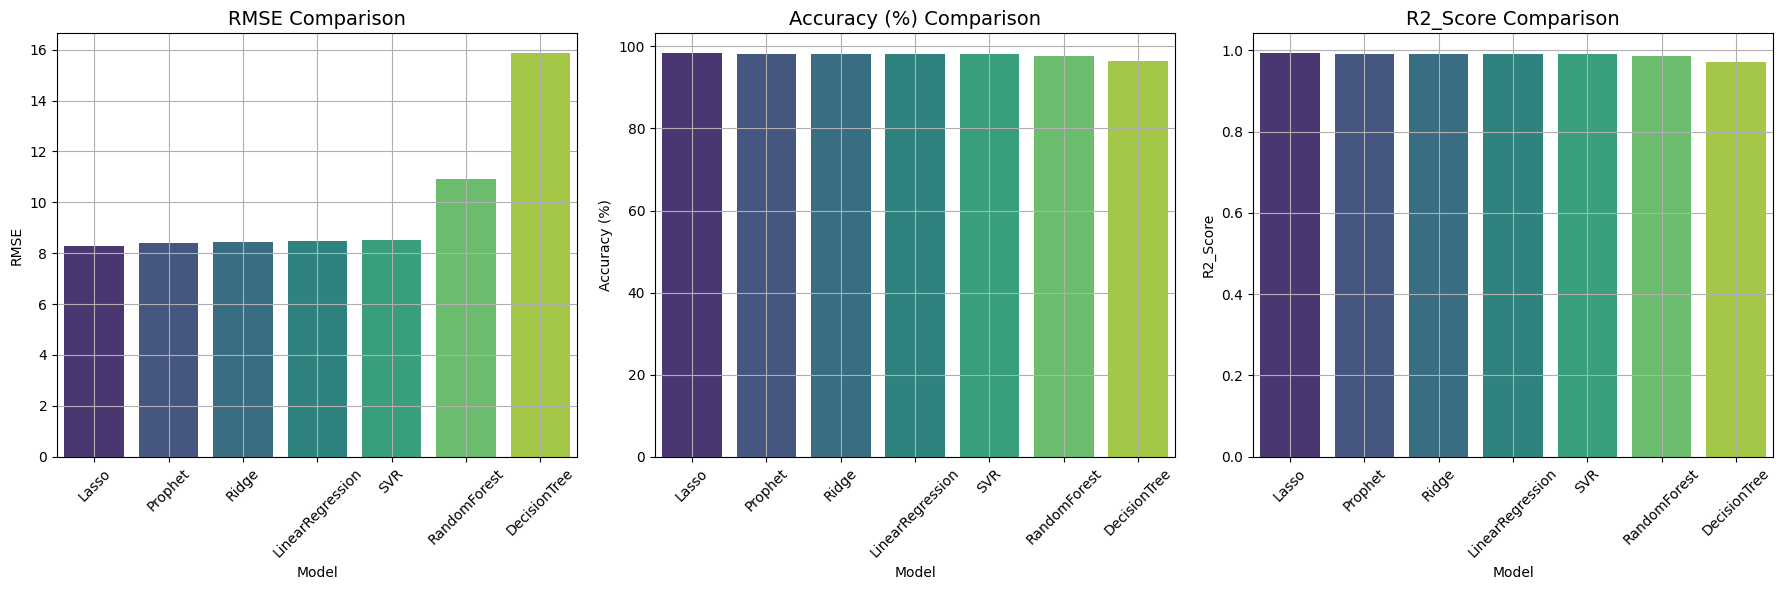

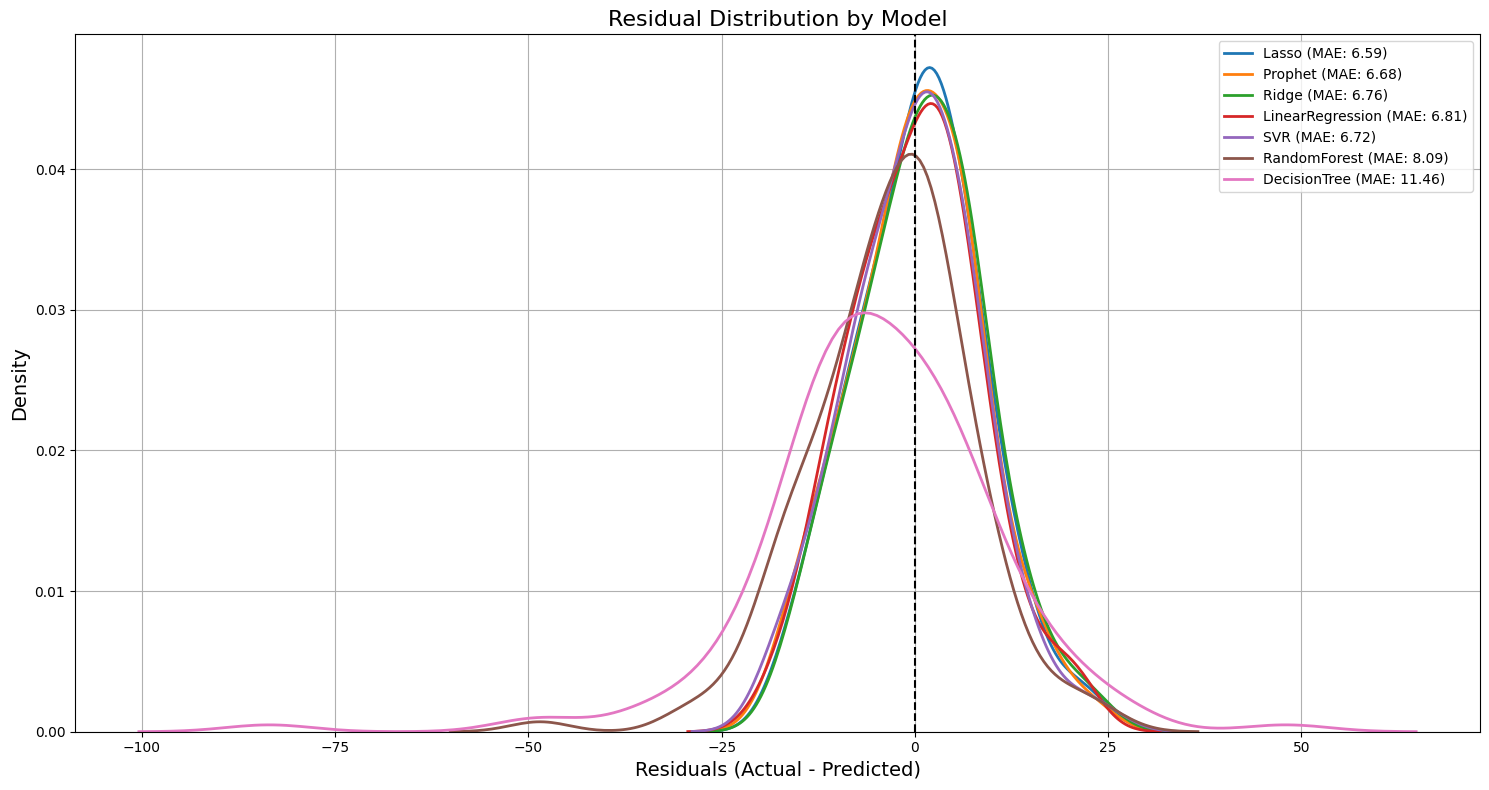

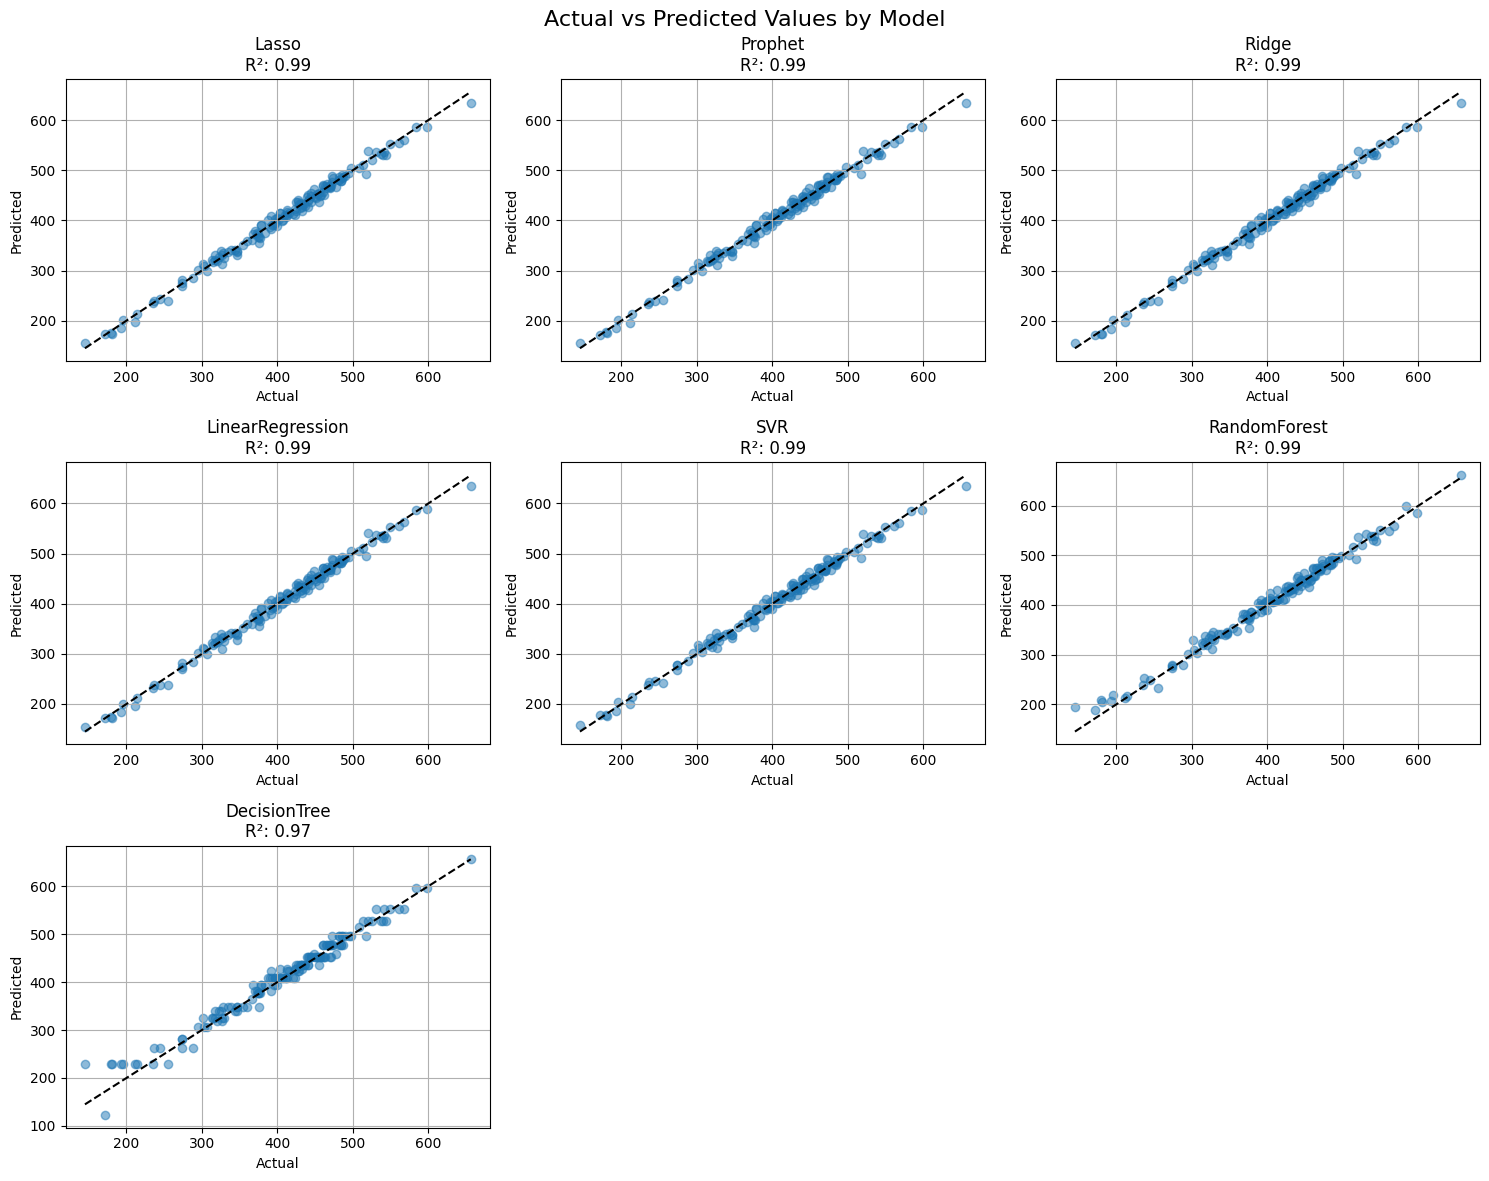


Plotting Actual vs Predicted for each model...

Plotting Test Set Predictions for each model...


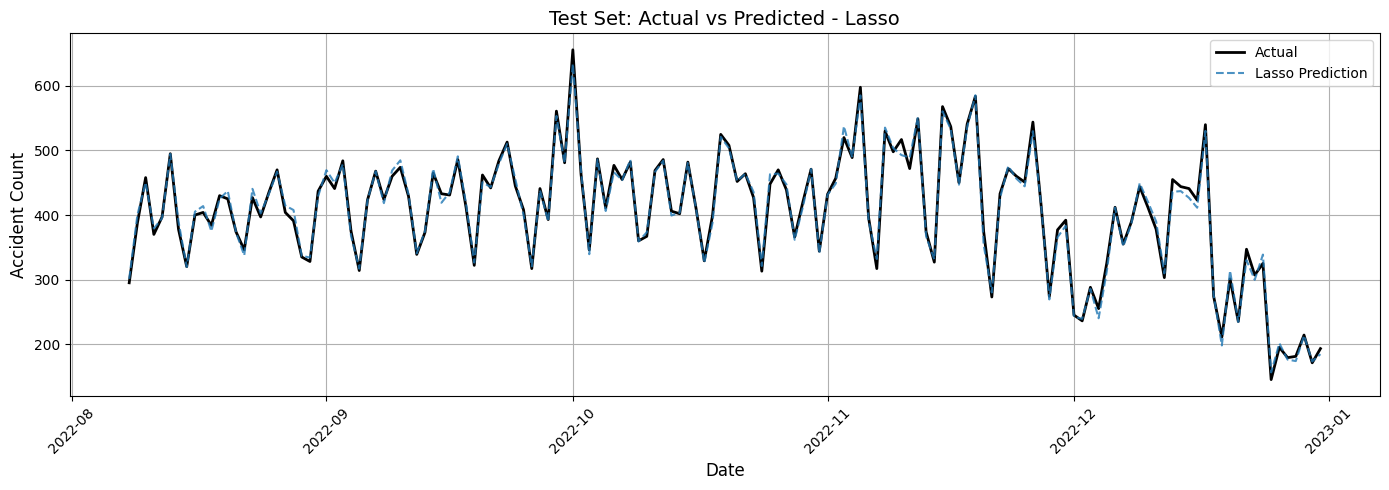

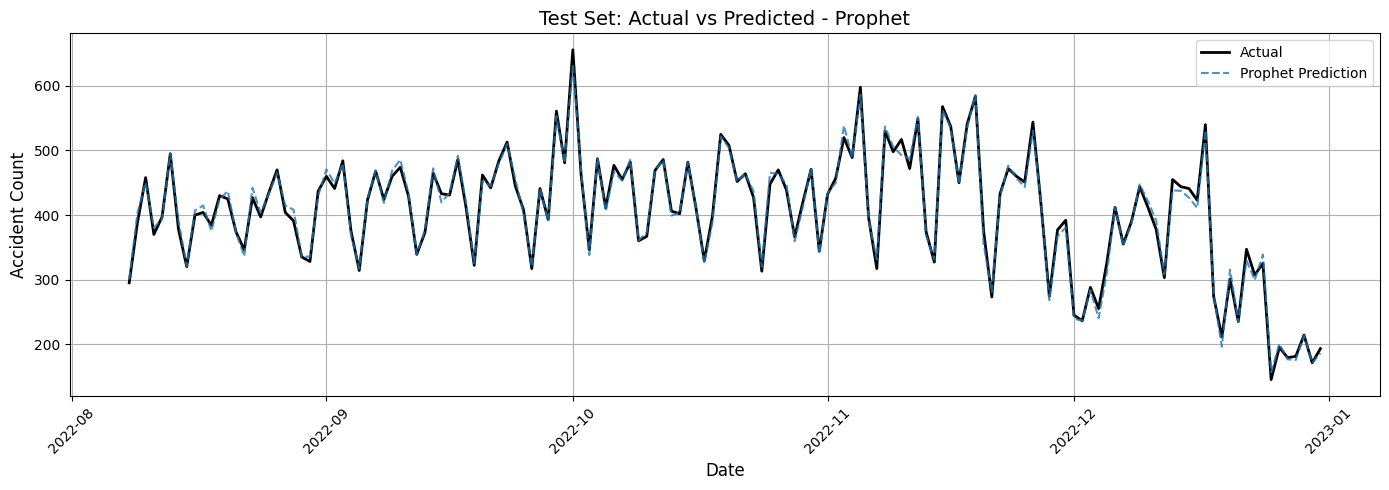

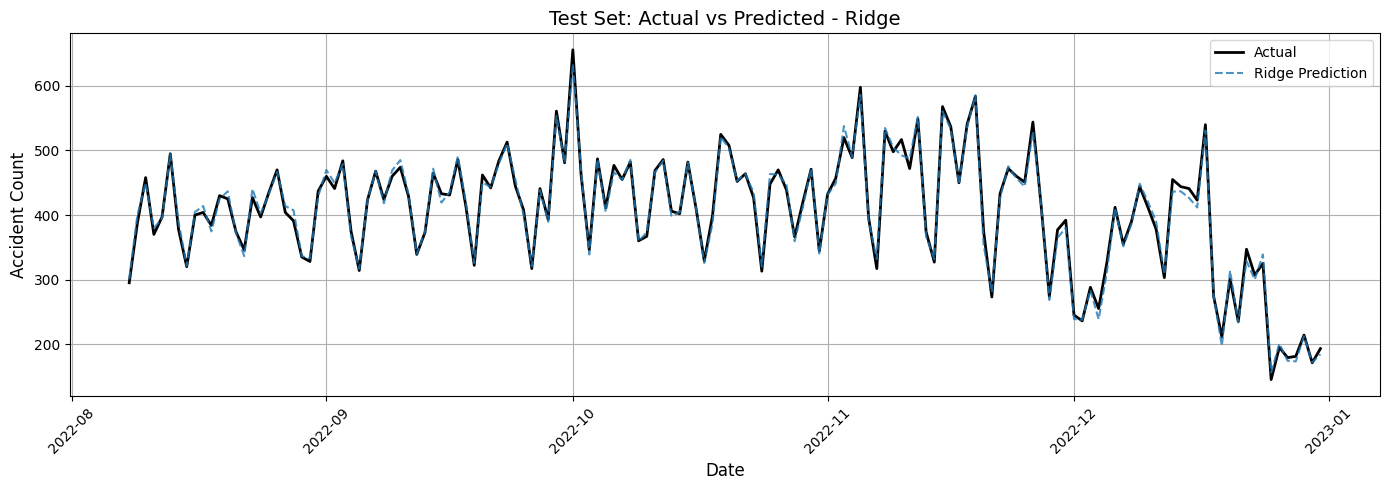

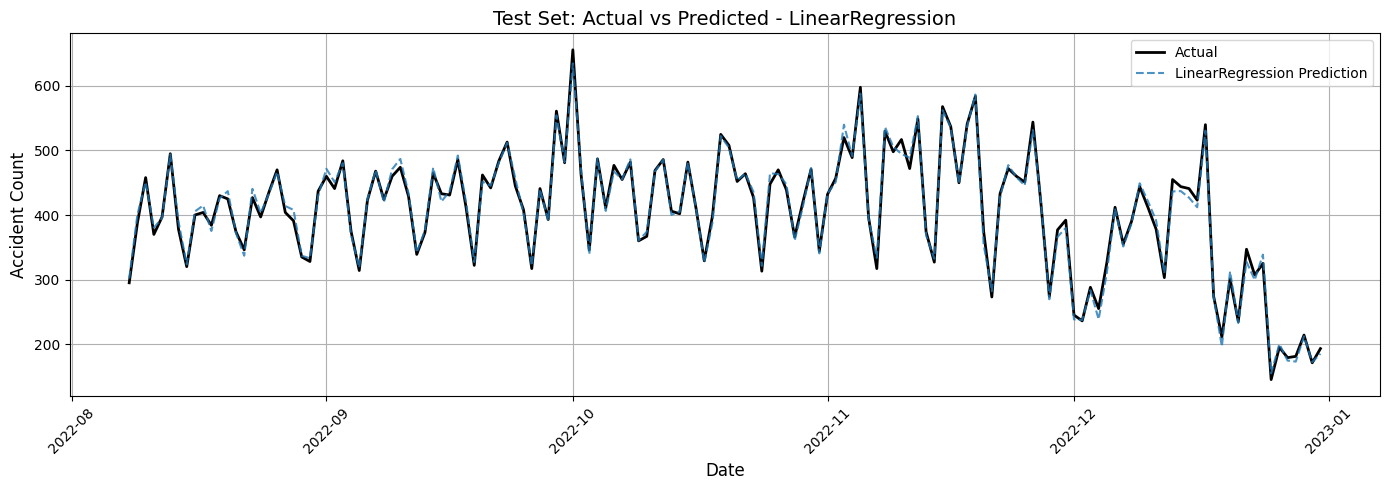

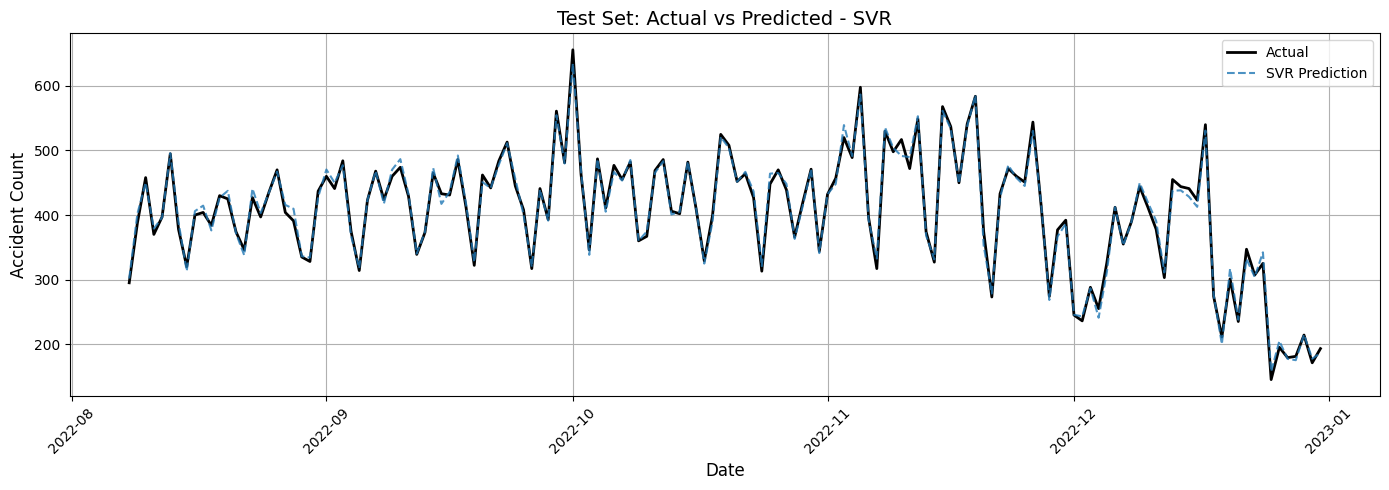

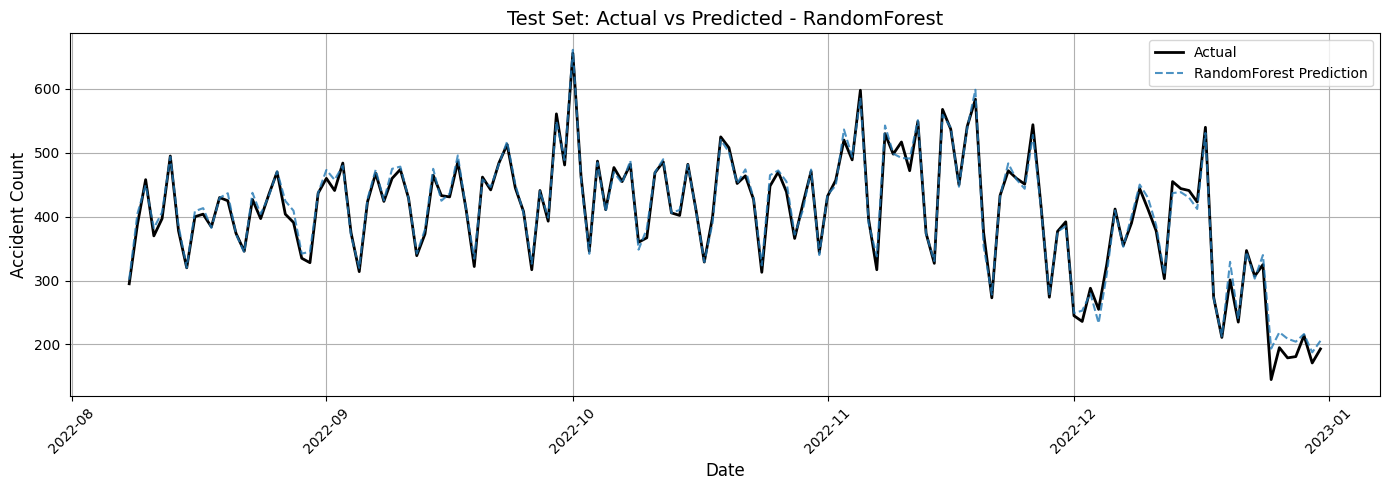

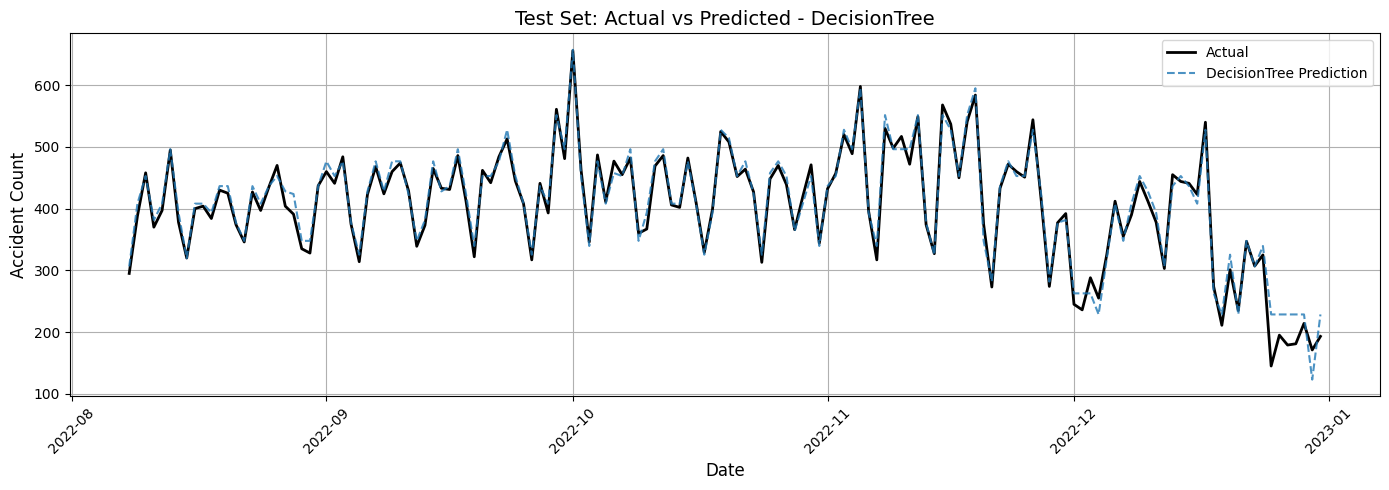

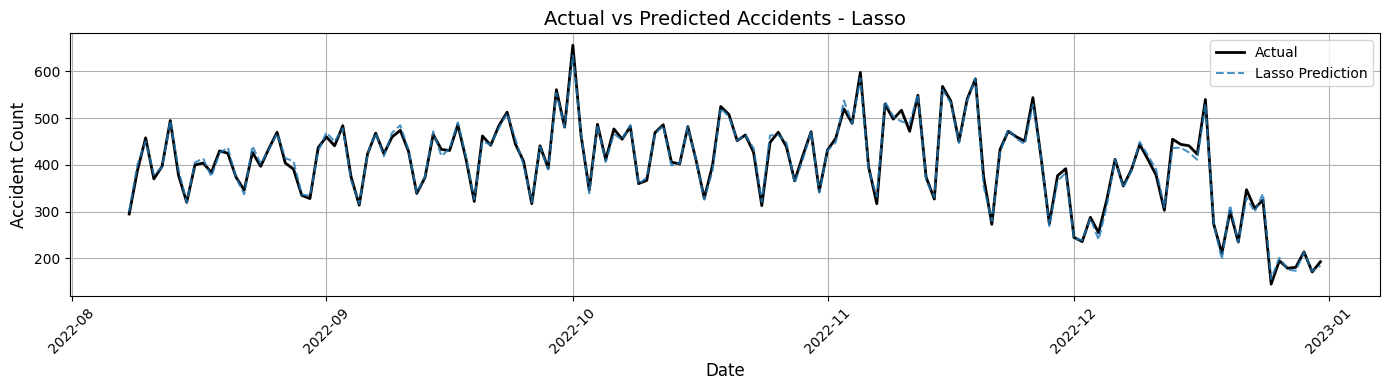

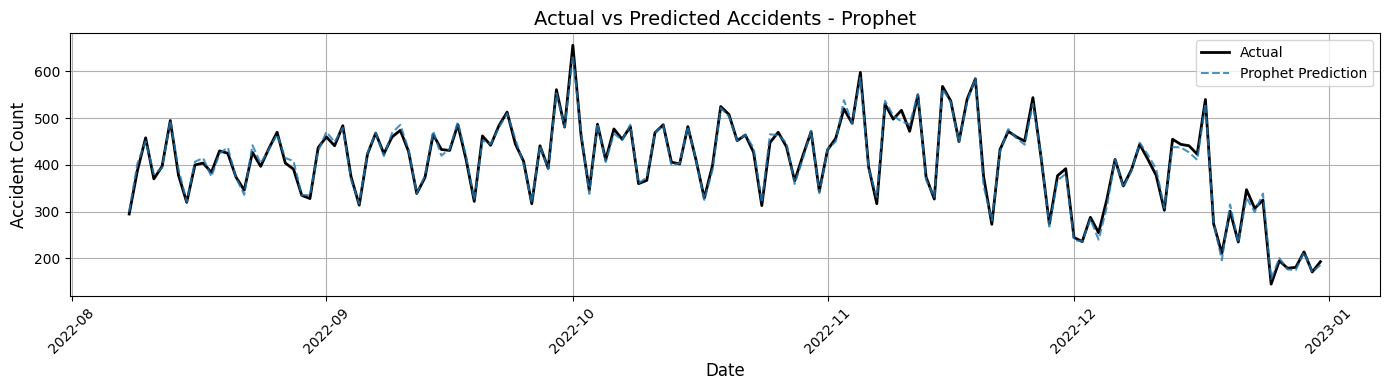

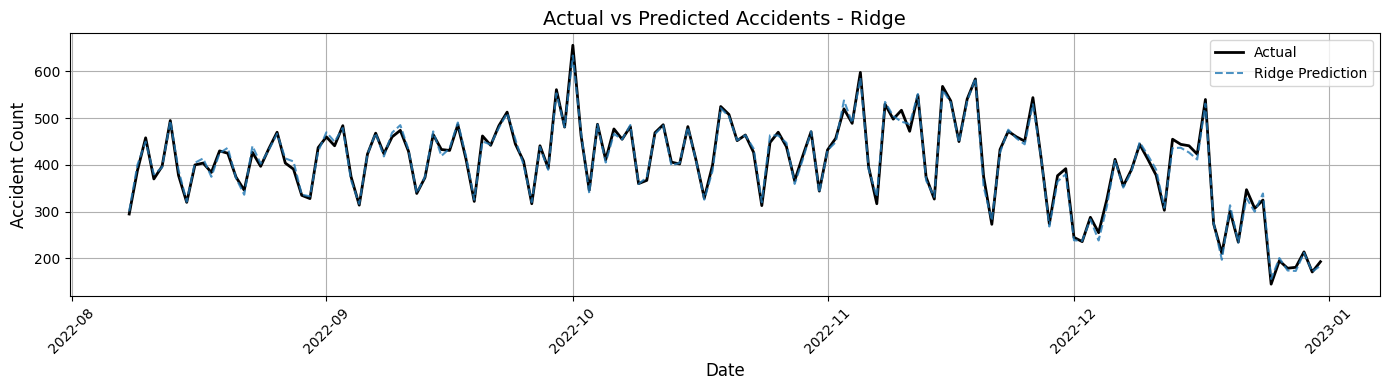

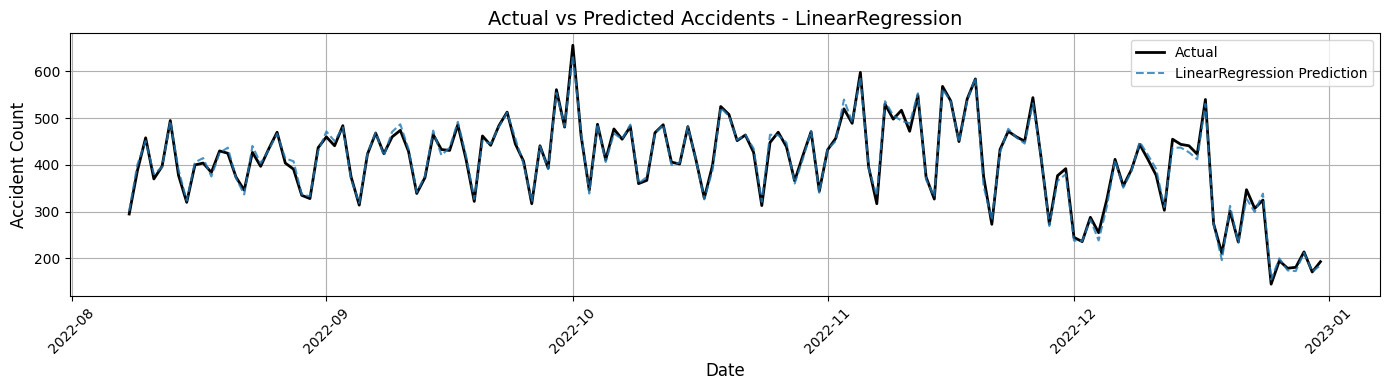

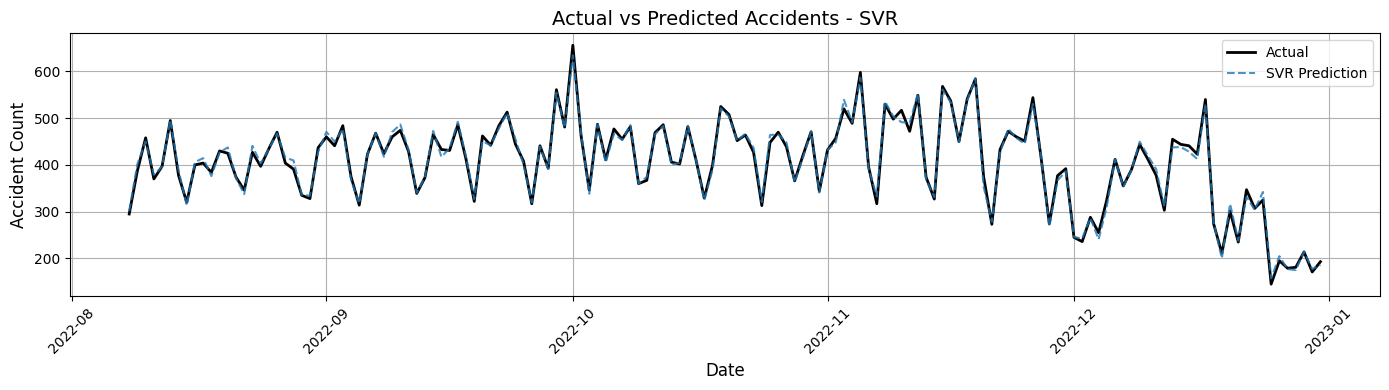

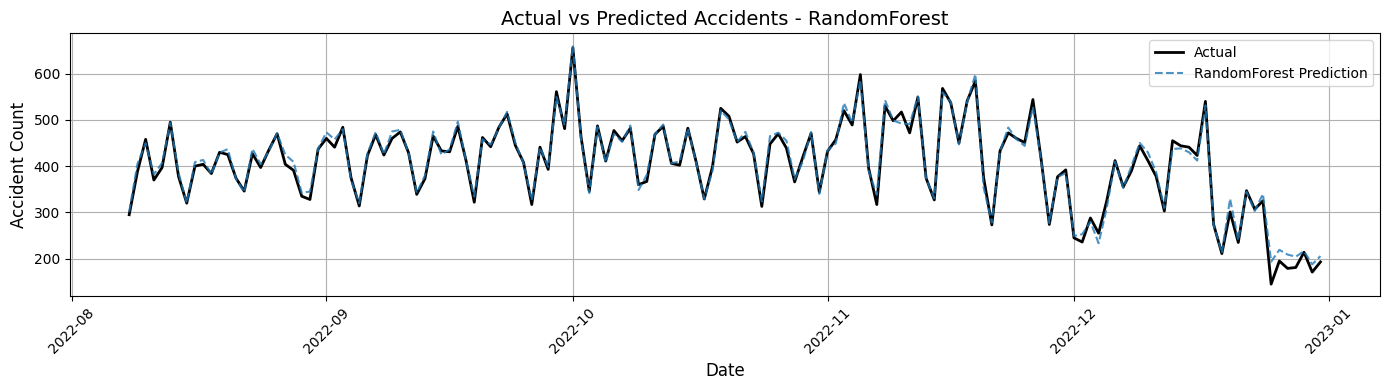

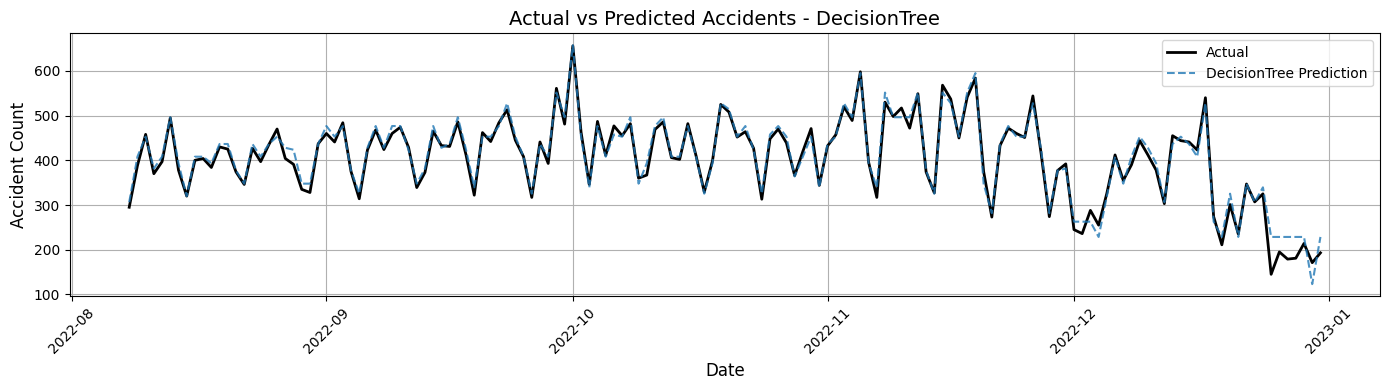

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric


# Data Preparation
df.dropna(subset=['Accident Date'], inplace=True)
df['Accident Date'] = pd.to_datetime(df['Accident Date'], dayfirst=True)

# Feature Engineering
df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour.fillna(0)
df['Minute'] = pd.to_datetime(df['Time'], errors='coerce').dt.minute.fillna(0)
df['Date'] = df['Accident Date'].dt.date
df['Day_of_Year'] = df['Accident Date'].dt.dayofyear
df['Week_of_Year'] = df['Accident Date'].dt.isocalendar().week
df['Month'] = df['Accident Date'].dt.month

# Group by date to get accident count per day
target = df.groupby('Date').size().reset_index(name='y')

# Aggregate features per day
agg_features = df.groupby('Date').agg({
    'Day_of_Week': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Junction_Control': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Junction_Detail': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Accident_Severity': 'mean',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Light_Conditions': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Local_Authority_(District)': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Carriageway_Hazards': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Number_of_Casualties': 'sum',
    'Number_of_Vehicles': 'sum',
    'Police_Force': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Road_Surface_Conditions': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Road_Type': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Speed_limit': 'mean',
    'Urban_or_Rural_Area': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Weather_Conditions': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Vehicle_Type': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'Hour': 'mean',
    'Minute': 'mean',
    'Day_of_Year': 'mean',
    'Week_of_Year': 'mean',
    'Month': 'mean'
}).reset_index()

data = pd.merge(target, agg_features, on='Date')

# Encode categorical columns
categorical_cols = [
    'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions',
    'Local_Authority_(District)', 'Carriageway_Hazards', 'Police_Force',
    'Road_Surface_Conditions', 'Road_Type', 'Urban_or_Rural_Area',
    'Weather_Conditions', 'Vehicle_Type'
]

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Convert Date to datetime and extract features
data['Date'] = pd.to_datetime(data['Date'])
data['ds'] = data['Date']
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['dayofweek'] = data['Date'].dt.dayofweek

# Split data
X = data.drop(columns=['y', 'Date', 'ds'])
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models & Grid
models = [
    {'name': 'LinearRegression', 'model': LinearRegression(), 'params': {}},
    {'name': 'Ridge', 'model': Ridge(), 'params': {'alpha': [0.1, 1, 10]}},
    {'name': 'Lasso', 'model': Lasso(max_iter=10000), 'params': {'alpha': [0.1, 1, 10]}},
    {'name': 'DecisionTree', 'model': DecisionTreeRegressor(), 'params': {'max_depth': [5, 10, 20]}},
    {'name': 'RandomForest', 'model': RandomForestRegressor(), 'params': {'n_estimators': [50, 100], 'max_depth': [5, 10]}},
    {'name': 'SVR', 'model': SVR(), 'params': {'kernel': ['linear', 'rbf'], 'C': [1, 10], 'gamma': ['scale', 'auto']}},
]

results = []

for item in models:
    print(f"Training {item['name']}...")
    grid = GridSearchCV(item['model'], item['params'], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 - (mape * 100)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': item['name'],
        'Best Params': grid.best_params_,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE (%)': round(mape * 100, 2),
        'Accuracy (%)': round(accuracy, 2),
        'R2_Score': round(r2, 4),
        'y_pred': y_pred,
        'model_obj': best_model
    })
# Prophet Model
print("Training Prophet...")
prophet_data = data[['ds', 'y']].copy()

# Add additional regressors from X and cast to float
for col in X.columns:
    prophet_data[col] = data[col].astype(float)

# Split into train/test (preserving time order)
train_size = int(len(prophet_data) * 0.8)
prophet_train = prophet_data.iloc[:train_size].copy()
prophet_test = prophet_data.iloc[train_size:].copy()

# Prophet hyperparameter grid
from itertools import product
prophet_params = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
param_combinations = [dict(zip(prophet_params.keys(), v)) for v in product(*prophet_params.values())]

prophet_results = []
best_prophet = None
best_prophet_rmse = float('inf')

for params in param_combinations[:5]:  # Try only first 5 combinations
    try:
        model = Prophet(**params)

        # Add all regressors
        for col in X.columns:
            model.add_regressor(col)

        model.fit(prophet_train)

        # Create future dataframe and add regressors
        future = model.make_future_dataframe(periods=len(prophet_test), freq='D')

        for col in X.columns:
            future[col] = np.concatenate([
                prophet_train[col].astype(float).values,
                prophet_test[col].astype(float).values
            ])

        forecast = model.predict(future)

        # Evaluate on test set
        test_forecast = forecast.iloc[-len(prophet_test):]
        y_true = prophet_test['y'].values
        y_pred = test_forecast['yhat'].values

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        prophet_results.append({
            'params': params,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

        if rmse < best_prophet_rmse:
            best_prophet_rmse = rmse
            best_prophet = model

    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        continue

# Add best Prophet results
if best_prophet:
    future = best_prophet.make_future_dataframe(periods=len(prophet_test), freq='D')
    for col in X.columns:
        future[col] = np.concatenate([
            prophet_train[col].astype(float).values,
            prophet_test[col].astype(float).values
        ])

    forecast = best_prophet.predict(future)
    test_forecast = forecast.iloc[-len(prophet_test):]
    y_pred_prophet = test_forecast['yhat'].values

    results.append({
        'Model': 'Prophet',
        'Best Params': prophet_results[np.argmin([x['RMSE'] for x in prophet_results])]['params'],
        'MAE': round(mean_absolute_error(prophet_test['y'], y_pred_prophet), 2),
        'RMSE': round(np.sqrt(mean_squared_error(prophet_test['y'], y_pred_prophet)), 2),
        'MAPE (%)': round(mean_absolute_percentage_error(prophet_test['y'], y_pred_prophet) * 100, 2),
        'Accuracy (%)': round(100 - (mean_absolute_percentage_error(prophet_test['y'], y_pred_prophet) * 100), 2),
        'R2_Score': round(r2_score(prophet_test['y'], y_pred_prophet), 4),
        'y_pred': y_pred_prophet,
        'model_obj': best_prophet
    })


results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("Model Comparison:")
print(results_df[['Model', 'Best Params', 'RMSE', 'Accuracy (%)', 'R2_Score']])


# ======================
#  Visualizations
# ======================

# 1. Time Series of Actual vs Predicted with Dates
plt.figure(figsize=(18, 8))
dates = data['Date'].iloc[-len(y_test):].values

plt.plot(dates, y_test.values, label='Actual', color='black', linewidth=2)

for i, row in enumerate(results_df.itertuples()):
    plt.plot(dates, row.y_pred, label=f"{row.Model} (RMSE: {row.RMSE:.2f})", 
             linestyle='--', alpha=0.8)

plt.title("Time Series of Actual vs Predicted Values", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Accident Count", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. SVM Support Vectors Visualization (using PCA for dimensionality reduction)
svm_row = results_df[results_df['Model'] == 'SVR']
if not svm_row.empty:
    svm_model = svm_row.iloc[0]['model_obj']
    
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    # Retrain SVM on PCA components (for visualization only)
    svm_pca = SVR(**svm_row.iloc[0]['Best Params'])
    svm_pca.fit(X_train_pca, y_train)
    
    # Create grid for decision boundary
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
    
    # Highlight support vectors
    sv_indices = svm_pca.support_
    plt.scatter(X_train_pca[sv_indices, 0], X_train_pca[sv_indices, 1], 
                facecolors='none', edgecolors='red', s=100, 
                label='Support Vectors')
    
    plt.colorbar(scatter, label='Accident Count')
    plt.title("SVM Decision Surface with Support Vectors (PCA Reduced)", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Random Forest Tree Visualization 
rf_row = results_df[results_df['Model'] == 'RandomForest']
if not rf_row.empty:
    rf_model = rf_row.iloc[0]['model_obj']
    
    # Plot one of the trees in the forest
    plt.figure(figsize=(20, 12))
    plot_tree(rf_model.estimators_[0], 
              feature_names=X.columns, 
              filled=True, 
              rounded=True, 
              max_depth=5,  
              proportion=True,
              fontsize=10)
    plt.title("Sample Decision Tree from Random Forest", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Random Forest Feature Importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices], color='skyblue', align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90, fontsize=12)
    plt.xlim([-1, X.shape[1]])
    plt.xlabel("Features", fontsize=14)
    plt.ylabel("Importance Score", fontsize=14)
    plt.tight_layout()
    plt.show()

# 4. Lasso Coefficient Path
lasso_row = results_df[results_df['Model'] == 'Lasso']
if not lasso_row.empty:
    alphas = np.logspace(-4, 2, 50)
    coefs = []
    
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X_train_scaled, y_train)
        coefs.append(lasso.coef_)
    
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.title("Lasso Coefficient Path", fontsize=16)
    plt.xlabel("Alpha (Regularization Strength)", fontsize=14)
    plt.ylabel("Coefficient Magnitude", fontsize=14)
    plt.axis('tight')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Prophet Components Plot
if best_prophet:
    fig = best_prophet.plot_components(forecast)
    plt.suptitle("Prophet Forecast Components", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Cross-validation
    df_cv = cross_validation(best_prophet, initial='365 days', period='180 days', horizon='90 days')
    df_p = performance_metrics(df_cv)
    
    # Plot cross-validation metrics
    fig = plot_cross_validation_metric(df_cv, metric='rmse')
    plt.title("Prophet Cross-Validation RMSE", fontsize=16)
    plt.tight_layout()
    plt.show()

# 6. Model Performance Comparison
metrics = ['RMSE', 'Accuracy (%)', 'R2_Score']

plt.figure(figsize=(18, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=results_df, palette='viridis')
    plt.title(f'{metric} Comparison', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Residual Analysis by Model
plt.figure(figsize=(15, 8))
for i, row in enumerate(results_df.itertuples()):
    residuals = y_test - row.y_pred
    sns.kdeplot(residuals, label=f"{row.Model} (MAE: {row.MAE:.2f})", linewidth=2)
    
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Residual Distribution by Model", fontsize=16)
plt.xlabel("Residuals (Actual - Predicted)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# 8. Actual vs Predicted Scatter Plots
import math

num_models = len(results_df)
cols = 3
rows = math.ceil(num_models / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
results_df.rename(columns={'R² Score': 'R2_Score'}, inplace=True)

for i, row in enumerate(results_df.itertuples()):
    plt.subplot(rows, cols, i+1)
    plt.scatter(y_test, row.y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.title(f"{row.Model}\nR²: {row.R2_Score:.2f}", fontsize=12)
    plt.xlabel("Actual", fontsize=10)
    plt.ylabel("Predicted", fontsize=10)
    plt.grid(True)

plt.suptitle("Actual vs Predicted Values by Model", fontsize=16)
plt.tight_layout()
plt.show()


print("\nPlotting Actual vs Predicted for each model...")

dates = data['Date'].iloc[-len(y_test):].values  
# ======================
# Testing Set Predictions (Line Plot per Model)
# ======================
print("\nPlotting Test Set Predictions for each model...")

dates = data['Date'].iloc[-len(y_test):].values

for i, row in enumerate(results_df.itertuples()):
    plt.figure(figsize=(14, 5))
    plt.plot(dates, y_test.values, label='Actual', color='black', linewidth=2)
    plt.plot(dates, row.y_pred, label=f'{row.Model} Prediction', linestyle='--', alpha=0.8)
    plt.title(f"Test Set: Actual vs Predicted - {row.Model}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Accident Count", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


for i, row in enumerate(results_df.itertuples()):
    plt.figure(figsize=(14, 4))
    plt.plot(dates, y_test.values, label='Actual', color='black', linewidth=2)
    plt.plot(dates, row.y_pred, label=f'{row.Model} Prediction', linestyle='--', alpha=0.8)
    
    plt.title(f"Actual vs Predicted Accidents - {row.Model}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Accident Count", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
